In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

%matplotlib inline

In [2]:
asking_for_help_MLdata = pd.read_csv('askingforhelp_data.csv')
cheating_MLdata = pd.read_csv('cheating_data.csv')

In [ ]:
#LOGISTIC REGRESSION

In [7]:
def run_lr_model(category):
    
    features = ['title', 'selftext']
    
    if category == 'asking for help':
        reddit_posts_df_1 = asking_for_help_MLdata
        reddit_posts_df = reddit_posts_df_1.replace(np.nan, 'thisismissingtext', regex=True)
        X = reddit_posts_df[features].fillna('thisismissingtext')
        y = reddit_posts_df['Asking for help'].fillna('thisismissingtext')
    elif category == 'cheating':
        reddit_posts_df_1 = cheating_MLdata
        reddit_posts_df = reddit_posts_df_1.replace(np.nan, 'thisismissingtext', regex=True)
        X = reddit_posts_df[features].fillna('thisismissingtext')
        y = reddit_posts_df['Cheating'].fillna('thisismissingtext')
        
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.50,
                                                    stratify=y)
    
    cv_text = CountVectorizer(stop_words='english', strip_accents = 'ascii', ngram_range=(1, 10))
    cv_title = CountVectorizer(stop_words='english', strip_accents = 'ascii', ngram_range=(1, 3))
    
    X_train_selftext = cv_text.fit_transform(X_train.selftext)
    X_train_title = cv_title.fit_transform(X_train.title)

    X_test_selftext = cv_text.transform(X_test.selftext)
    X_test_title = cv_title.transform(X_test.title)

    X_train_selftext_df = pd.DataFrame(X_train_selftext.todense(), columns=[x+'_text' for x in cv_text.get_feature_names_out()])
    
    X_train_title_df = pd.DataFrame(X_train_title.todense(), columns=[y+'_title' for y in cv_title.get_feature_names_out()])

    X_test_selftext_df = pd.DataFrame(X_test_selftext.todense(), columns=[x+'_text' for x in cv_text.get_feature_names_out()])
    
    X_test_title_df = pd.DataFrame(X_test_title.todense(), columns=[y+'_title' for y in cv_title.get_feature_names_out()])

    vecced_train_reddit_posts = pd.concat([X_train_selftext_df, X_train_title_df], axis=1)
    vecced_test_reddit_posts = pd.concat([X_test_selftext_df, X_test_title_df], axis=1)
    
    lr_params = {
        'penalty': ['l1'],
        'C': [1, 1.5, 2, 2.5],
        'class_weight': ['balanced'],
        'warm_start': [True, False],
        'random_state': [42],
        'solver': ['liblinear']}
        
    M = GridSearchCV(LogisticRegression(),
                        lr_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
    M.fit(vecced_train_reddit_posts.values, y_train)
     
    print(f'Train score = {M.score(vecced_train_reddit_posts.values, y_train)}')
    print(f'Test score = {M.score(vecced_test_reddit_posts.values, y_test)}')
    
    predictions = M.predict(vecced_test_reddit_posts.values)
    print('--------')
    cm = confusion_matrix(y_test, predictions)
    print(cm)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=20)
    
    ax.xaxis.set_label_position('top') 
    
    if category == 'asking for help':
        ax.xaxis.set_ticklabels(['asking for help', 'not asking for help'], fontsize = 10)
        ax.xaxis.tick_top()

        ax.set_ylabel('True', fontsize=20)
        ax.yaxis.set_ticklabels(['asking for help', 'not asking for help'], fontsize = 10)
    
    elif category == 'cheating':
        ax.xaxis.set_ticklabels(['cheating', 'not cheating'], fontsize = 10)
        ax.xaxis.tick_top()

        ax.set_ylabel('True', fontsize=20)
        ax.yaxis.set_ticklabels(['cheating', 'not cheating'], fontsize = 10)
    
    
    plt.show()
    print(f'Best params = {M.best_params_}')
    

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Train score = 0.9955476402493322
Test score = 0.9661921708185054
--------
[[407  24]
 [ 14 679]]


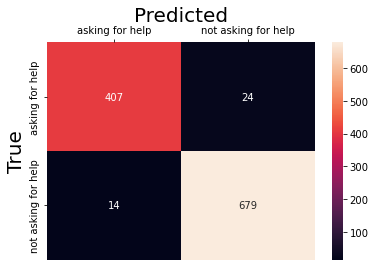

Best params = {'C': 1.5, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'warm_start': True}


In [8]:
run_lr_model('asking for help')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Train score = 0.9510240427426536
Test score = 0.9128113879003559
--------
[[588  23]
 [ 75 438]]


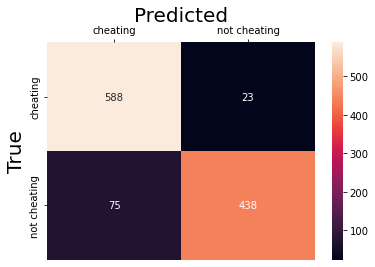

Best params = {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'warm_start': True}


In [9]:
run_lr_model('cheating')

In [10]:
#MULTINOMIAL NAIVE BAYES

In [13]:
def run_mn_model(category):

    features = ['title', 'selftext']
    
    if category == 'asking for help':
        reddit_posts_df_1 = asking_for_help_MLdata
        reddit_posts_df = reddit_posts_df_1.replace(np.nan, 'thisismissingtext', regex=True)
        X = reddit_posts_df[features].fillna('thisismissingtext')
        y = reddit_posts_df['Asking for help'].fillna('thisismissingtext')
    elif category == 'cheating':
        reddit_posts_df_1 = cheating_MLdata
        reddit_posts_df = reddit_posts_df_1.replace(np.nan, 'thisismissingtext', regex=True)
        X = reddit_posts_df[features].fillna('thisismissingtext')
        y = reddit_posts_df['Cheating'].fillna('thisismissingtext')
        
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.50,
                                                    stratify=y)
    
    cv_text = CountVectorizer(stop_words='english', strip_accents = 'ascii', ngram_range=(1, 10))
    cv_title = CountVectorizer(stop_words='english', strip_accents = 'ascii', ngram_range=(1, 3))
    
    X_train_selftext = cv_text.fit_transform(X_train.selftext)
    X_train_title = cv_title.fit_transform(X_train.title)

    X_test_selftext = cv_text.transform(X_test.selftext)
    X_test_title = cv_title.transform(X_test.title)

    X_train_selftext_df = pd.DataFrame(X_train_selftext.todense(), columns=[x+'_text' for x in cv_text.get_feature_names_out()])
    
    X_train_title_df = pd.DataFrame(X_train_title.todense(), columns=[y+'_title' for y in cv_title.get_feature_names_out()])

    X_test_selftext_df = pd.DataFrame(X_test_selftext.todense(), columns=[x+'_text' for x in cv_text.get_feature_names_out()])
    
    X_test_title_df = pd.DataFrame(X_test_title.todense(), columns=[y+'_title' for y in cv_title.get_feature_names_out()])

    vecced_train_reddit_posts = pd.concat([X_train_selftext_df, X_train_title_df], axis=1)
    vecced_test_reddit_posts = pd.concat([X_test_selftext_df, X_test_title_df], axis=1)
    
        
    mn_params = {
        'fit_prior': [True],
        'alpha': [0, 0.5, 1]}
        
    M = GridSearchCV(MultinomialNB(),
                    mn_params,
                    cv = 5,
                    verbose = 1,
                    n_jobs = -1)
        
        
    M.fit(vecced_train_reddit_posts.values, y_train)
     
    print(f'Train score = {M.score(vecced_train_reddit_posts.values, y_train)}')
    print(f'Test score = {M.score(vecced_test_reddit_posts.values, y_test)}')
    
    predictions = M.predict(vecced_test_reddit_posts.values)
    print('--------')
    cm = confusion_matrix(y_test, predictions)
    print(cm)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('top') 
    if category == 'asking for help':
        ax.xaxis.set_ticklabels(['asking for help', 'not asking for help'], fontsize = 10)
        ax.xaxis.tick_top()

        ax.set_ylabel('True', fontsize=20)
        ax.yaxis.set_ticklabels(['asking for help', 'not asking for help'], fontsize = 10)
    
    elif category == 'cheating':
        ax.xaxis.set_ticklabels(['cheating', 'not cheating'], fontsize = 10)
        ax.xaxis.tick_top()

        ax.set_ylabel('True', fontsize=20)
        ax.yaxis.set_ticklabels(['cheating', 'not cheating'], fontsize = 10)
    
    plt.show()
    print(f'Best params = {M.best_params_}')



Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/krishmaha/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Train score = 0.9982190560997328
Test score = 0.9537366548042705
--------
[[411  20]
 [ 32 661]]


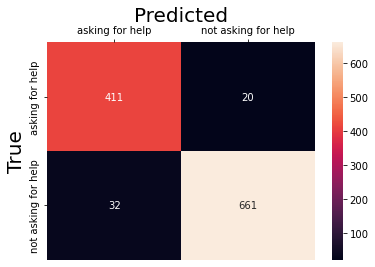

Best params = {'alpha': 0, 'fit_prior': True}


/Users/krishmaha/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/krishmaha/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/krishmaha/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


In [14]:
run_mn_model('asking for help')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/krishmaha/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Train score = 0.9902048085485308
Test score = 0.9181494661921709
--------
[[589  22]
 [ 70 443]]


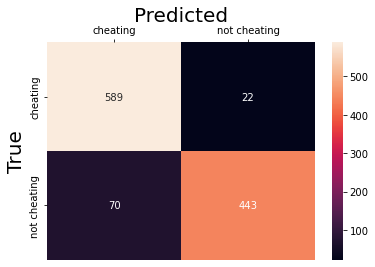

Best params = {'alpha': 0, 'fit_prior': True}


/Users/krishmaha/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


In [15]:
run_mn_model('cheating')